# NDReg
## 0. Preamble
In order to fully understand the following analysis, some key terms must be defined:

- The **Error** between two volumes is the sum of squared errors between their voxels

- Given images a and b, and function f(), the  **Error Reduction Rate** is calculated as: $\frac{\bigg{|}\text{squaredError}(a,b) - \text{squaredError}(a, f(b))\bigg{|}}{\text{squaredError}(a, b)}$

## 1.Simulation Data
### 1. Write the distributions that I will use to test the code
#### Functionality Testing
I will obtain the functionality testing data from the NDReg tutorial notebooks. The functionality testing data will be an image of a brain, and an atlas that must be aligned to said image.
#### i. 
The solution for this registration should be the same as the solution detailed in the jupyter documentation here:
https://github.com/neurodata/ndreg/blob/master/doc/3D_STP_RegistrationTest.ipynb

#### ii.
I expect this test to perform very well as it is the test used in the example notebook detailing how to run the NDReg pipeline

#### Validation Testing
In order to test the validity of the code, I will be creating code that generates a random synthetic synapse volume, and then performs a random rigid body transformationon the data. The randomly generated volume will have similar size and density statistics as the real world data. Specifically, it will have:

- 98% non-synapse voxels, 2% synapse voxels
- synapse clusters of .2 microns$^3$, or ~27 voxels

Additionally, the random rigid body transformation will account for having up to 5% imaging error in any singular dimension.

### 2. Write code to sample the data
#### Functionality Testing
The code below prepares the functionality testing data by pulling it from NDio

In [23]:
import sys
sys.path.insert(0, '../../../ndreg/')
import ndreg

refImg = ndreg.imgDownload('ara_ccf2')
refAnnoImg = ndreg.imgDownload('ara_ccf2', channel="annotation")
inImg = ndreg.imgDownload('eacker01', 'r', 5)

#reorient and rescale the test image
inImgReor = ndreg.imgReorient(inImg, 'lsp', 'rsa')
inImg_ds = ndreg.imgResample(inImgReor, spacing=[.25, .25, .25])
refImg_ds = ndreg.imgResample(refImg, spacing=[.25, .25, .25])

#### Validation Testing
The code below generates a random volume and applies a rigid body transform according to the specifications in **Simulation Data, Section 1**

In [77]:
import math
import numpy as np
import SimpleITK as itk
from random import randrange as rand
from random import uniform as floatRand
from affine import Affine

def generatePointSet():
    center = (rand(0, 99), rand(0, 99), rand(0, 99))
    toPopulate = []
    for z in range(-1, 2):
        for y in range(-1, 2):
            for x in range(-1, 2):
                curPoint = (center[0]+z, center[1]+y, center[2]+x)               
                #only populate valid points
                valid = True
                for dim in range(3):
                    if curPoint[dim] < 0 or curPoint[dim] >= 100:
                        valid = False
                        
                if valid:
                    toPopulate.append(curPoint)
            
    return set(toPopulate)                       
   
def getTransform():
    #generate a random rigid body transform
    #error is assumed to be 5% rotationally
    #and laterally
    a = floatRand(-.15, .15)
    b = floatRand(-.15, .15)
    c = floatRand(-.15, .15)
    
    xt = floatRand(-2.5, 2.5)
    yt = floatRand(-2.5, 2.5)
    zt = floatRand(-2.5, 2.5)
    
    transform = np.stack([
        [math.cos(a)*math.cos(b), math.cos(a)*math.sin(b)*math.sin(c)-math.sin(a)*math.cos(c), math.cos(a)*math.sin(b)*math.cos(c)+math.sin(a)*math.sin(c), xt],
        [math.sin(a)*math.cos(b), math.sin(a)*math.sin(b)*math.sin(c)+math.cos(a)*math.cos(c), math.sin(a)*math.sin(b)*math.cos(c)-math.cos(a)*math.sin(c), yt],
        [-math.sin(b), math.cos(b)*math.sin(c), math.cos(b)*math.cos(c), zt],
        [0., 0., 0., 1.]
    ])
    return transform
    
    
def applyRigid(initialVolume, transform):
    rigidMatrix = np.zeros_like(initialVolume)    
    for z in range(initialVolume.shape[0]):
        for y in range(initialVolume.shape[1]):
            for x in range(initialVolume.shape[2]):
                new = np.dot(transform, [x + initialVolume.shape[2]/2., y + initialVolume.shape[1]/2., z + initialVolume.shape[0]/2., 1])
                try:
                    rigidMatrix[int(new[2]-initialVolume.shape[2]/2.)][int(new[1]-initialVolume.shape[1]/2.)][int(new[0]-initialVolume.shape[0]/2.)] = initialVolume[z][y][x]
                #if transformed place is out of bounds, dont deal with it
                except IndexError:
                        continue
    return rigidMatrix
    
def generateTestVolume():
    #create a test volume
    volume = np.zeros((100, 100, 100))
    myPointSet = set()
    for _ in range(rand(500, 800)):
        potentialPointSet = generatePointSet()
        #be sure there is no overlap
        while len(myPointSet.intersection(potentialPointSet)) > 0:
                potentialPointSet = generatePointSet()
        for elem in potentialPointSet:
            myPointSet.add(elem)
    
    #populate the true volume
    for elem in myPointSet:
        volume[elem[0], elem[1], elem[2]] = 60000
        
    #introduce noise
    noiseVolume = np.copy(volume)
    for z in range(noiseVolume.shape[0]):
        for y in range(noiseVolume.shape[1]):
            for x in range(noiseVolume.shape[2]):
                if not (z, y, x) in myPointSet:
                    noiseVolume[z][y][x] = rand(0, 10000)
      
    #convert numpy array to itk image
    itkVolume = itk.GetImageFromArray(noiseVolume)
    
    #perform a random rigid body transform to generate the second volume
    transform = getTransform()
    rigidMatrix = applyRigid(noiseVolume, transform)
    
    rigidVolume = itk.GetImageFromArray(rigidMatrix)
    return itkVolume, rigidVolume, transform

#### i.
This generation routing will return two volumes, the itkVolume and the rigidVolume. The itkVolume is the untranslated data, which can be used as the groundtruth for the registration operation.
#### ii.
I expect the algorithm to perfrom very well since the magnitude of the transform is extremely low at 5%

### 3. Describe what I think simulations will look like
#### Functionality
I expect the functionality results to be identical to the results outlined in the NDReg documentation notebook. The notebook is linked in **Simulation Data - Functionality Testing - 1 - i.**
#### Validation
I expect the validation data to have an **Error Reduction Rate** that is proportional to the number of iterations of gradient descent performed in the algorithm. I do not, however, have a prediction for the cap error reduction rate that will be achieved.

### 4/5. Write code to plot and plot the simulated data
#### Generation routine testing
The following code will apply random rigid body transformations to an initial image with two simple clusters in it, and display the results to confirm that small, valid transformations are being made.

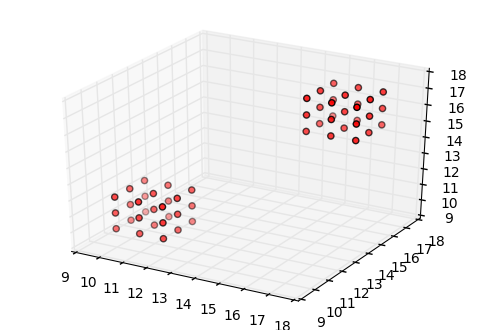

In [29]:
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import label

twoCluster = pickle.load(open('../code/tests/synthDat/twoPerfectClusters.synth'))

#pre transform
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
z, y, x = twoCluster.nonzero()
ax.scatter(x, y, z, zdir='z', c='r')
plt.show()

[[  9.99962872e-01  -2.14552509e-03  -8.34570654e-03   1.43137715e+00]
 [  1.68336014e-03   9.98485176e-01  -5.49956254e-02   1.74286167e+00]
 [  8.45105876e-03   5.49795347e-02   9.98451717e-01  -2.30062859e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00]]


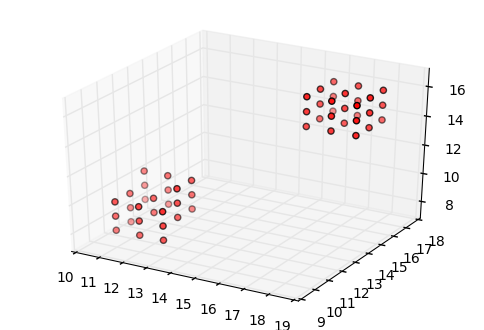

[[ 0.99785895  0.00368891  0.06529864  0.8242531 ]
 [-0.00349449  0.99998912 -0.00309139 -1.99007683]
 [-0.06530933  0.00285658  0.99786098 -1.93170394]
 [ 0.          0.          0.          1.        ]]


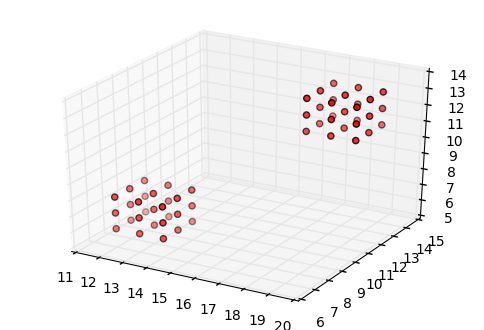

[[ 0.99936093  0.02271438  0.0276005   2.27024643]
 [-0.02136089  0.99860049 -0.04838158  1.30978737]
 [-0.02866083  0.04776109  0.99844751 -1.76397857]
 [ 0.          0.          0.          1.        ]]


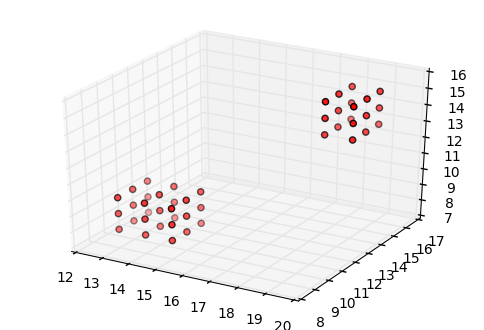

In [19]:
for i in range(3):
    #post transform
    transform = getTransform()
    post = applyRigid(twoCluster, transform)   
    print transform
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    z, y, x = post.nonzero()
    ax.scatter(x, y, z, zdir='z', c='r')
    plt.show()

### 6. Report on the simulated data

- From the visualizations provided, I can confirm that the transformation function is successfully transforming the data with a small rigid body transform.

- The validity of the random cluster generation routine (i.e. generateTestVolume) has already been investigated and reported on throrughly here:

### 7. Failure Case

I am not going to test NDReg's failure cases through data; rather, I am going to test them through hyperparameter variation. It is my expectation that modulating the number of gradient descent iterations of the algorithm will cause failure and success cases to appear on their own.

## Simulation Analysis
### 1. Pseudocode
Below is the pseudocode for NDReg's (poorly named) imgAffineComposite funciton.

#### **INPUTS & OUTPUTS**

##### Parameters
- inImg_ds -> The image two be aligned
- refImage_ds -> The image which inImg_ds is being aligned to
- iterations -> The number of iterations to run the algorithm
- useMI -> Whether or not to use MI (Mutual Information)
- verbose -> Whether or not to print progress and debug data

##### Input Space
The main inputs to this algorithm are 2 3D volumes of the same data type inImg_ds and refImage_ds

##### Output Space
The output of this algorithm is a matrix superposition of 4 transformations in this order:
1. Translation
2. Scaling
3. Rigid
4. Affine

The pseudocode for the algorithm is below:

In [ ]:
######################################
###THIS IS PSEUDOCODE; WILL NOT RUN###
######################################

def algorithm(inImg_ds, refImg_ds, iterations, useMI = False, verbose = False):
    translation = randomTranslation()
    for iteration in iterations:
        newImg = applyTranslation(inImg_ds, translation)
        loss = squaredError(newImg, refImg_ds)
        translation = gradientDescentStep(translation, loss)
    
    baseImg = newImg    
    scale = randomScale()
    for iteration in iterations:
        newImg = applyScale(baseImg, scale)
        loss = squaredError(newImg, refImg_ds)
        scale = gradientDescentStep(scale, loss)
    
    baseImg = newImg    
    rigid = randomRigid()
    for iteration in iterations:
        newImg = applyRigid(baseImg, rigid)
        loss = squaredError(newImg, refImg_ds)
        rigid = gradientDescentStep(rigid, loss)
    
    baseImg = newImg    
    affine = randomAffine()
    for iteration in iterations:
        newImg = applyAffine(baseImg, affine)
        loss = squaredError(newImg, refImg_ds)
        affine = gradientDescentStep(affine, loss)
        
    
    return translation * scale * rigid * affine

## 2. Algorithm Code

In [20]:
def register(inImg, baseImg, iterations):
    return ndreg.imgAffineComposite(inImg,
                              baseImg,
                              iterations=iterations,
                              useMI=False,
                              verbose=False)

## 3. Predicted functionality simulation performance
Please refer to **Simulation Data - Section 1 - i**

## 4. Write code to plot simulated data
Since attempting to visualize the transformation on the simulated volumes is very difficult, the transformations will be applied to this function in order to help with visualizing the exact distortions of the transformation

In [33]:
def visualizeTransform(transform):
    twoCluster = pickle.load(open('../code/tests/synthDat/twoPerfectClusters.synth'))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    z, y, x = twoCluster.nonzero()
    ax.scatter(x, y, z, zdir='z', c='r')
    plt.show()
    post = applyRigid(twoCluster, transform)   
    print transform
    fig2 = plt.figure()
    ax = fig2.add_subplot(111, projection='3d')
    z, y, x = post.nonzero()
    ax.scatter(x, y, z, zdir='z', c='r')
    plt.show()

## 5. Plot raw simulated data
### Functionality Data
Below are the plots of the atlas and the brain image to be aligned for the functionality test.

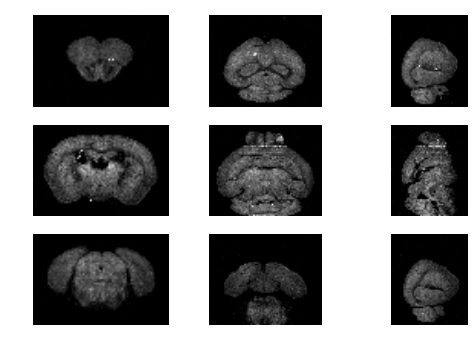

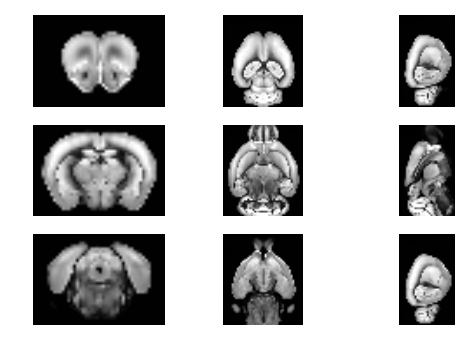

In [24]:
#display the images to be registered
ndreg.imgShow(inImg_ds, vmax=10000)
ndreg.imgShow(refImg_ds, vmax=500)

### Validation Data
Below is a demonstration of a random rigid transform on a synthetic body and a visualization space

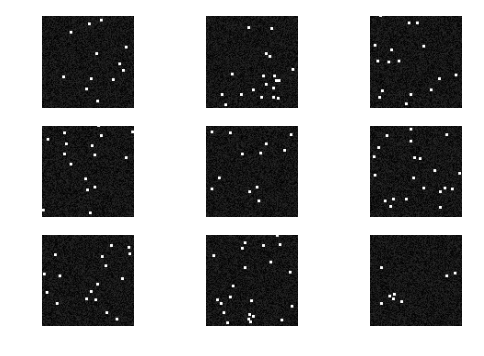

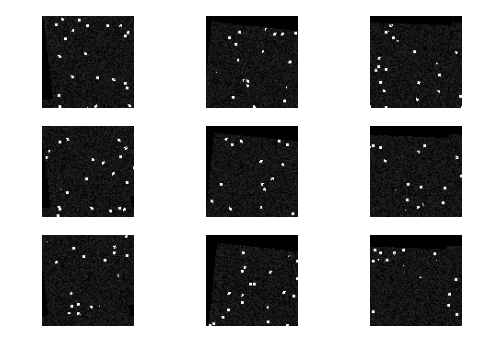

Transformation Visualization:


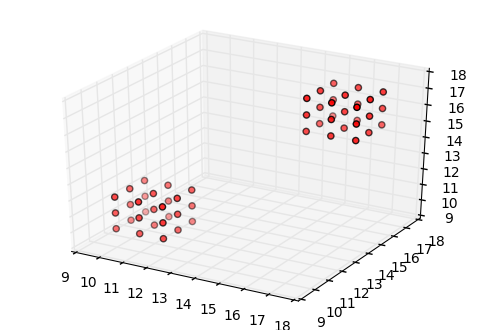

[[ 0.98683421  0.12022296 -0.10818822  2.38179968]
 [-0.12514987  0.99133357 -0.03994073  0.50434174]
 [ 0.10244882  0.05295462  0.99332776 -1.86083686]
 [ 0.          0.          0.          1.        ]]


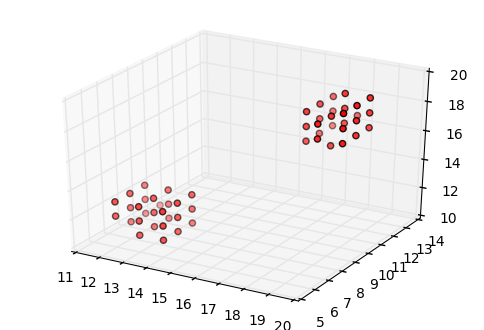

In [78]:
baseVolumeImg, transformedVolumeImg, transform = generateTestVolume()

#base volume image
ndreg.imgShow(baseVolumeImg)
#transformed volume image
ndreg.imgShow(transformedVolumeImg)
#transformation visualization
print 'Transformation Visualization:'
visualizeTransform(transform)